In [1]:
import sys
sys.path.append('../scripts')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import helpers as hp
import pickle as pkl
import os

from keras.layers import Input, Dense, LSTM, Embedding, Merge
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adadelta
from keras.callbacks import Callback
from keras import backend as K

from sklearn.metrics import f1_score, precision_score, recall_score,\
                            average_precision_score, roc_auc_score,\
                            roc_curve, precision_recall_curve, confusion_matrix,\
                            accuracy_score

from IPython.core.interactiveshell import InteractiveShell
from matplotlib import rcParams
from importlib import reload
from harness import TrainingHarness

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'times new roman'

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

/home/paperspace/anaconda3/envs/python-36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Data Preprocessing

In [2]:
with open('../data/embeddings/glove-300.map', 'rb') as f:
    map = pkl.load(f)

data_dir = os.path.join('..','data')
source_dir = os.path.join(data_dir,'split','amazon-google')
data = hp.load_data(source_dir)

datasets = ['train_1', 'val_1', 'test_1', 'train_2', 'val_2', 'test_2']

# drop columns that do not contain embeddings
data['train_1'] = data['train_1'].drop(['id1', 'price'], axis = 'columns')
data['train_2'] = data['train_2'].drop(['id2', 'price'], axis = 'columns')
data['val_1'] = data['val_1'].drop(['id1', 'price'], axis = 'columns')
data['val_2'] = data['val_2'].drop(['id2', 'price'], axis = 'columns')
data['test_1'] = data['test_1'].drop(['id1', 'price'], axis = 'columns')
data['test_2'] = data['test_2'].drop(['id2', 'price'], axis = 'columns')


# concatenate all embedding columns so each record becomes one giant list
def concat_columns(x):
    x = x['title'] + x['description'] + x['manufacturer']
    return x

for df_name in datasets:
    data[df_name] = data[df_name].apply(concat_columns, axis='columns')
    
# pad all sequences with less than 500 indices with zeros
# limit all sequences to 500 indices
maxlen = 500
for df_name in datasets:
    data[df_name] = pad_sequences(data[df_name], maxlen=maxlen)

# Build Model

In [3]:
glove_matrix = np.load(os.path.join(data_dir, 
                                    'embeddings',
                                    'glove-300.matrix.npy'))

In [4]:
n_hidden = 50
gradient_clipping_norm = 1.25

input_left = Input(shape=(maxlen,))
input_right = Input(shape=(maxlen,))

embedding_layer = Embedding(glove_matrix.shape[0],
                            glove_matrix.shape[1],
                            weights=[glove_matrix],
                            input_length=maxlen,
                            trainable=False)
embedded_left = embedding_layer(input_left)
embedded_right = embedding_layer(input_right)

lstm_layer = LSTM(n_hidden)
output_left = lstm_layer(embedded_right)
output_right = lstm_layer(embedded_left)

def distance_metric(x1, x2):
    l1 = -K.sum(K.abs(x1 - x2), axis=1, keepdims=True)
    return K.exp(l1)

merge_layer = Merge(mode=lambda x: distance_metric(x[0], x[1]),
                    output_shape=lambda x: (x[0][0], 1))
distance = merge_layer([output_left, output_right])

malstm = Model([input_left, input_right], [distance])

/home/paperspace/anaconda3/envs/python-36/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


# Pre-training

In [20]:
compile_args = dict(optimizer='adam',
                    loss='mean_squared_error',
                    metrics=['acc'])
fit_args = dict(x = [data['train_1'], data['train_2']],
                  y = data['train_y'],
                  epochs = 10,
                  batch_size = 2048,
                  validation_data = ([data['val_1'], data['val_2']], data['val_y']))
th = TrainingHarness(malstm,
                     n_checkpoints = 10,
                     compile_args = compile_args,
                     fit_args = fit_args,
                     npy_embedding_matrix = '../data/embeddings/glove-300.matrix.npy')

In [36]:
th.fit(class_weight = {0:1, 1:5}, epochs = 100)

Train on 10400 samples, validate on 1300 samples
Epoch 1/1
10400/10400 [==============================] - 9s 889us/step - loss: 0.0423 - acc: 0.9939 - val_loss: 0.0704 - val_acc: 0.9077
Train on 10400 samples, validate on 1300 samples
Epoch 1/1
10400/10400 [==============================] - 9s 906us/step - loss: 0.0438 - acc: 0.9926 - val_loss: 0.0693 - val_acc: 0.9100
Train on 10400 samples, validate on 1300 samples
Epoch 1/1
10400/10400 [==============================] - 10s 917us/step - loss: 0.0428 - acc: 0.9935 - val_loss: 0.0698 - val_acc: 0.9077
Train on 10400 samples, validate on 1300 samples
Epoch 1/1
10400/10400 [==============================] - 9s 880us/step - loss: 0.0401 - acc: 0.9939 - val_loss: 0.0690 - val_acc: 0.9062
Train on 10400 samples, validate on 1300 samples
Epoch 1/1
10400/10400 [==============================] - 9s 895us/step - loss: 0.0380 - acc: 0.9941 - val_loss: 0.0697 - val_acc: 0.9085
Train on 10400 samples, validate on 1300 samples
Epoch 1/1
10400/1040

Train on 10400 samples, validate on 1300 samples
Epoch 1/1
10400/10400 [==============================] - 9s 897us/step - loss: 0.0341 - acc: 0.9953 - val_loss: 0.0693 - val_acc: 0.9092
Train on 10400 samples, validate on 1300 samples
Epoch 1/1
10400/10400 [==============================] - 9s 881us/step - loss: 0.0363 - acc: 0.9949 - val_loss: 0.0696 - val_acc: 0.9069
Train on 10400 samples, validate on 1300 samples
Epoch 1/1
10400/10400 [==============================] - 9s 876us/step - loss: 0.0343 - acc: 0.9953 - val_loss: 0.0693 - val_acc: 0.9069
Train on 10400 samples, validate on 1300 samples
Epoch 1/1
10400/10400 [==============================] - 9s 893us/step - loss: 0.0346 - acc: 0.9957 - val_loss: 0.0693 - val_acc: 0.9077
Train on 10400 samples, validate on 1300 samples
Epoch 1/1
10400/10400 [==============================] - 9s 906us/step - loss: 0.0323 - acc: 0.9957 - val_loss: 0.0693 - val_acc: 0.9100
Train on 10400 samples, validate on 1300 samples
Epoch 1/1
10400/10400

10400/10400 [==============================] - 9s 899us/step - loss: 0.0299 - acc: 0.9965 - val_loss: 0.0689 - val_acc: 0.9077
Train on 10400 samples, validate on 1300 samples
Epoch 1/1
10400/10400 [==============================] - 9s 911us/step - loss: 0.0303 - acc: 0.9968 - val_loss: 0.0680 - val_acc: 0.9085
Train on 10400 samples, validate on 1300 samples
Epoch 1/1
10400/10400 [==============================] - 9s 905us/step - loss: 0.0300 - acc: 0.9968 - val_loss: 0.0687 - val_acc: 0.9069
Train on 10400 samples, validate on 1300 samples
Epoch 1/1
10400/10400 [==============================] - 9s 903us/step - loss: 0.0288 - acc: 0.9974 - val_loss: 0.0682 - val_acc: 0.9085
Train on 10400 samples, validate on 1300 samples
Epoch 1/1
10400/10400 [==============================] - 9s 904us/step - loss: 0.0274 - acc: 0.9968 - val_loss: 0.0684 - val_acc: 0.9108
Train on 10400 samples, validate on 1300 samples
Epoch 1/1
10400/10400 [==============================] - 9s 886us/step - loss: 0

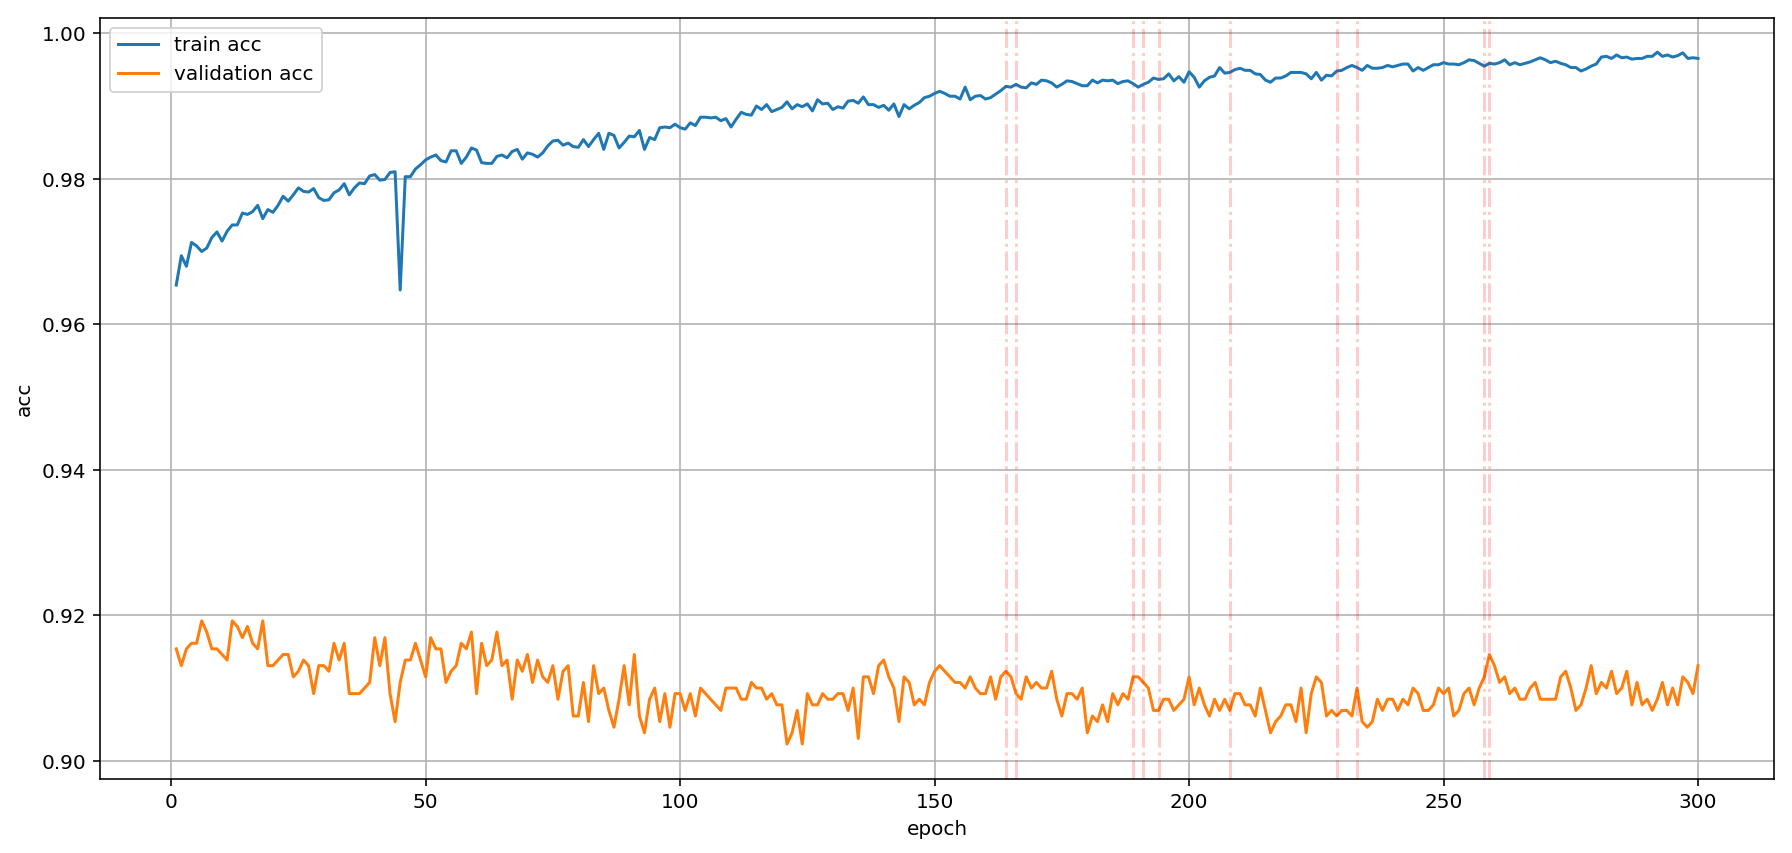

In [40]:
th.plot_history('acc')

In [42]:
y_train_pred = th.model.predict([data['train_1'], data['train_2']])
y_val_pred = th.model.predict([data['val_1'], data['val_2']])

In [60]:
confusion_matrix(data['train_y'], y_train_pred >= 0.5)

array([[9326,   26],
       [  10, 1038]])

In [62]:
confusion_matrix(data['val_y'], y_val_pred >= 0.3)

array([[1081,  106],
       [  63,   50]])

(array([889., 156.,  84.,  54.,  45.,  28.,  18.,   9.,   5.,  12.]),
 array([1.45307516e-11, 9.13808763e-02, 1.82761753e-01, 2.74142629e-01,
        3.65523505e-01, 4.56904382e-01, 5.48285258e-01, 6.39666134e-01,
        7.31047010e-01, 8.22427887e-01, 9.13808763e-01]),
 <a list of 10 Patch objects>)

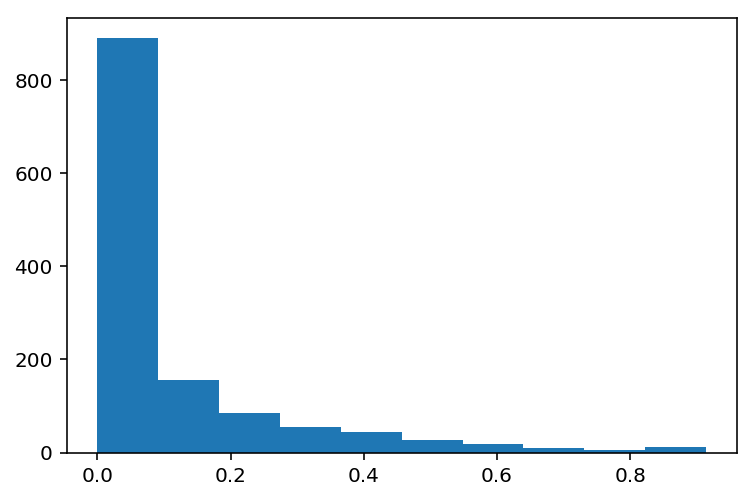

In [58]:
plt.hist(y_val_pred)

(array([7294., 1216.,  527.,  210.,   73.,   40.,   31.,  145.,  538.,
         326.]),
 array([7.77698503e-18, 9.35717642e-02, 1.87143528e-01, 2.80715293e-01,
        3.74287057e-01, 4.67858821e-01, 5.61430585e-01, 6.55002350e-01,
        7.48574114e-01, 8.42145878e-01, 9.35717642e-01]),
 <a list of 10 Patch objects>)

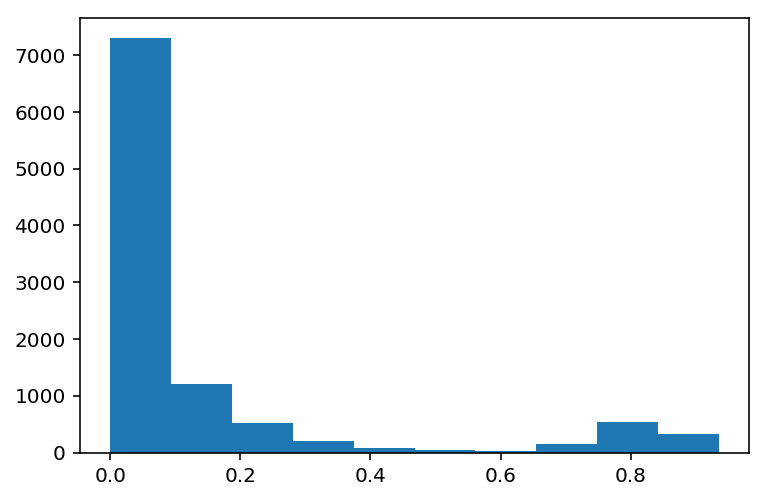

In [59]:
plt.hist(y_train_pred)

In [66]:
with open('../data/embeddings/glove-300.map', 'rb') as f:
    map = pkl.load(f)

In [64]:
val_1 = pd.read_csv('../data/split/amazon-google/val_1.csv')
val_2 = pd.read_csv('../data/split/amazon-google/val_2.csv')

In [82]:
import helpers as hp

def indices_to_words(x):
    string = ''
    for idx in x:
        string = string + ' ' + map['idx2word'][idx]
    return string

val_1_str = val_1[['title', 'description', 'manufacturer']].applymap(hp.str_to_list)
val_2_str = val_2[['title', 'description', 'manufacturer']].applymap(hp.str_to_list)

val_1_str = val_1_str.applymap(indices_to_words)
val_2_str = val_2_str.applymap(indices_to_words)

In [94]:
y_val_pred >= 0.5

array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

In [98]:
val_str = pd.concat([val_1_str, val_2_str], axis = 'columns')
val_str.loc[(y_val_pred >= 0.5).squeeze() & ~(data['val_y'].squeeze()), :]

,title,description,manufacturer,title,description,manufacturer
147,roxio toast 8 titanium,roxio toast 8 sets the standard for burning c...,roxio,onone software <unk> - on1 essentials <unk> f...,onone software <unk> : make it better cut it ...,<unk>
198,calendar creator platinum sb cs by Riverdeep,calendar creator platinum new for 2007 is the...,encore software,absolute software <unk> - Computrace lojack f...,absolute software <unk> : a laptop is stolen ...,<unk>
203,rome total war gold edition,rome : total war gold puts you in command of ...,sega of america inc.,encore software 14110 - jeopardy ! deluxe - w...,encore software 14110 : do you have what it t...,<unk>
443,gsp crossword addict,crossword addict ( win 95 98 me 2000 xp ),global software publishing north america inc,custom land designer 3d 7.0,overview everything you need to easily create...,<unk>
596,ultra sudoku / ultra kakuro,ultra sudoku / kakuro prepares you for hours ...,abacus,sony playstation 2 : grand turismo 4,new and enhanced racing modes include : gt di...,<unk>
631,emedia piano and keyboard method volume 1,piano and keyboard method is a powerful and o...,emedia,viva media llc 00257 - my sim aquarium - win ...,viva media llc 00257 : my sim aquarium is a v...,<unk>
664,dv rack 2 win retail <unk>,- marketing information : dv rack hd 2 is dir...,adobe,adobe after effects professional 7 software f...,after effects professional 7 software for win...,<unk>
685,microsoft virtual pc for mac 7.0 with windows...,virtual pc 7 with windows xp home makes it ea...,microsoft,total training for advanced flash 8 - action ...,learn how to unleash your creative potential ...,<unk>
706,treasure <unk>,math learning tool for ages 5 - 9,the learning company,hoyle game collection - 4 game pack,this game collection includes four full-versi...,<unk>
711,Zoboomafoo animal logic cd / workbook combo,learning through <unk> <unk> Zoboomafoo chris...,brighter minds media inc.,classics the : the piano ( audio book ),a new worldwide audio standard for classical ...,<unk>
